In [14]:
import os
import sys
import json
import tensorflow as tf
from transformers import DistilBertTokenizer
project_root = '/Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio'
sys.path.insert(0, project_root)
os.chdir('../')

In [15]:
from models.sentiment_model import EnhancedDistilBertForSentiment, ModelTrainer  # Add this import
from config.model_config import Config
from main import SentimentAnalyzer
from models.modelPersistence import ModelPersistence
from utils.modelEvaluator import ModelEvaluator

In [19]:
def load_model(model_path, return_config=True):
    """Load a trained model and associated artifacts
    
    Args:
        model_path (str): Path to the saved model directory
        return_config (bool): Whether to return the saved configuration
        
    Returns:
        tuple: (loaded_model, loaded_tokenizer, config) if return_config=True
               (loaded_model, loaded_tokenizer) if return_config=False
               
    Raises:
        FileNotFoundError: If model directory or required files are missing
        ValueError: If loaded model/config is incompatible
    """
    try:
        # Validate directory exists
        if not os.path.exists(model_path):
            raise FileNotFoundError(f"Model directory not found: {model_path}")
            
        # Load model
        model_full_path = os.path.join(model_path, "full_model")
        if not os.path.exists(model_full_path):
            raise FileNotFoundError(f"Model not found in directory: {model_full_path}")
            
        print("Loading model architecture and weights...")
        loaded_model = tf.keras.models.load_model(model_full_path)
        
        # Load tokenizer
        tokenizer_path = os.path.join(model_path, "tokenizer")
        if not os.path.exists(tokenizer_path):
            raise FileNotFoundError(f"Tokenizer not found in directory: {tokenizer_path}")
            
        print("Loading tokenizer...")
        loaded_tokenizer = DistilBertTokenizer.from_pretrained(tokenizer_path)
        
        # Load config if requested
        if return_config:
            config_path = os.path.join(model_path, "config.json")
            if not os.path.exists(config_path):
                raise FileNotFoundError(f"Config file not found: {config_path}")
                
            print("Loading model configuration...")
            with open(config_path, 'r') as f:
                config = json.load(f)
                
            # Validate configuration
            required_keys = ['model_params', 'training_params', 'performance']
            if not all(key in config for key in required_keys):
                raise ValueError("Invalid config file: missing required sections")
                
            # Verify model architecture matches config
            model_config = config['model_params']
            if loaded_model.get_layer('bi_lstm').units != model_config['lstm_units']:
                raise ValueError("Loaded model architecture doesn't match saved configuration")
                
            return loaded_model, loaded_tokenizer, config
            
        return loaded_model, loaded_tokenizer
        
    except Exception as e:
        print(f"Error loading model: {str(e)}")
        raise

def initialize_analyzer_from_saved(model_path):
    """Initialize a SentimentAnalyzer with a saved model
    
    Args:
        model_path (str): Path to the saved model directory
        
    Returns:
        SentimentAnalyzer: Initialized analyzer with loaded model
    """
    try:
        # Load model components
        loaded_model, loaded_tokenizer, config = load_model(model_path)
        
        # Initialize analyzer with loaded model
        analyzer = SentimentAnalyzer(model=loaded_model)
        analyzer.tokenizer = loaded_tokenizer
        
        # Initialize trainer
        analyzer.trainer = ModelTrainer(loaded_model, loaded_tokenizer)
        
        print(f"Successfully loaded model from: {model_path}")
        print("\nModel Configuration:")
        print(json.dumps(config['model_params'], indent=2))
        print("\nModel Performance:")
        print(json.dumps(config['performance'], indent=2))
        
        return analyzer
        
    except Exception as e:
        print(f"Error initializing analyzer: {str(e)}")
        raise

In [33]:
import os
project_path = "/Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio"
model_path = "/Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/saved_models/model_v2.0.0_epoch6"
# First verify the paths
print("Checking paths:")
print(f"Project directory: {project_path}")
print(f"Model directory: {model_path}")
print("\nVerifying model directory contents:")
if os.path.exists(model_path):
    print(os.listdir(model_path))
else:
    print("Model directory not found. Please verify the path.")

Checking paths:
Project directory: /Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio
Model directory: /Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio/saved_models/model_v2.0.0_epoch6

Verifying model directory contents:
['config.json', 'tokenizer', 'full_model']


In [37]:
import os
import json
import tensorflow as tf
from transformers import DistilBertTokenizer
from models.sentiment_model import ModelTrainer, EnhancedDistilBertForSentiment
from data.data_processing import DataProcessor
from config.model_config import Config
from main import SentimentAnalyzer

# Set paths
project_path = "/Users/tayebekavousi/Desktop/sentimentAnalysisPortfolio"
model_path = os.path.join(project_path, "saved_models/model_v2.0.0_epoch6")

try:
    # Load configuration
    with open(os.path.join(model_path, "config.json"), 'r') as f:
        saved_config = json.load(f)
    print("\nSaved model configuration:")
    print(json.dumps(saved_config, indent=2))

    # Initialize a new model with the same architecture
    print("\nInitializing model architecture...")
    model = EnhancedDistilBertForSentiment()
    
    # Create a dummy input to build the model
    dummy_input = {
        'input_ids': tf.zeros((1, Config.MAX_LENGTH), dtype=tf.int32),
        'attention_mask': tf.zeros((1, Config.MAX_LENGTH), dtype=tf.int32)
    }
    _ = model(dummy_input)  # Build the model
    
    # Load saved weights
    print("\nLoading model weights...")
    model.load_weights(os.path.join(model_path, "full_model", "variables", "variables"))
    
    # Load tokenizer
    print("\nLoading tokenizer...")
    loaded_tokenizer = DistilBertTokenizer.from_pretrained(os.path.join(model_path, "tokenizer"))

    # Initialize analyzer
    analyzer = SentimentAnalyzer(model=model)
    analyzer.tokenizer = loaded_tokenizer
    analyzer.trainer = ModelTrainer(model, loaded_tokenizer)
    analyzer.data_processor = DataProcessor()

    # Test the loaded model
    test_texts = [
        "The food was absolutely amazing! Best restaurant experience ever!",
        "Service was terrible and the food was cold.",
        "It was okay, nothing special but nothing terrible either."
    ]
    
    print("\nTesting model with sample reviews:")
    for text in test_texts:
        result = analyzer.predict(text)
        print(f"\nInput: {text}")
        print("Prediction:", json.dumps(result, indent=2))

except Exception as e:
    print(f"Error loading model: {str(e)}")
    import traceback
    traceback.print_exc()

else:
    print("\nModel loaded successfully! Ready for predictions.")


Saved model configuration:
{
  "model_params": {
    "bert_model": "distilbert-base-uncased",
    "lstm_units": 96,
    "feature_dim": 48,
    "fusion_layers": [
      192,
      96
    ],
    "dropout_rates": [
      0.5,
      0.6
    ],
    "num_classes": 3
  },
  "training_params": {
    "max_length": 128,
    "batch_size": 32,
    "learning_rate": 1e-05,
    "num_epochs": 10
  },
  "performance": {
    "final_train_accuracy": 0.7326666712760925,
    "final_val_accuracy": 0.67405766248703,
    "best_val_accuracy": 0.6784922480583191
  }
}

Initializing model architecture...


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.



Loading model weights...

Loading tokenizer...

Testing model with sample reviews:

Input: The food was absolutely amazing! Best restaurant experience ever!
Prediction: {
  "sentiment": {
    "negative": 0.24364201724529266,
    "neutral": 0.24836772680282593,
    "positive": 0.507990300655365
  },
  "predicted": "positive",
  "sarcasm_detected": false,
  "sarcasm_type": null
}

Input: Service was terrible and the food was cold.
Prediction: {
  "sentiment": {
    "negative": 0.521393895149231,
    "neutral": 0.23939840495586395,
    "positive": 0.2392076998949051
  },
  "predicted": "negative",
  "sarcasm_detected": false,
  "sarcasm_type": null
}

Input: It was okay, nothing special but nothing terrible either.
Prediction: {
  "sentiment": {
    "negative": 0.4140312671661377,
    "neutral": 0.3139500021934509,
    "positive": 0.2720187306404114
  },
  "predicted": "negative",
  "sarcasm_detected": false,
  "sarcasm_type": null
}

Model loaded successfully! Ready for predictions.


In [39]:
def test_sentiment_edge_cases(analyzer):
   """
   Test sentiment analyzer with various edge cases organized by sentiment and linguistic pattern.
   
   Args:
       analyzer: Initialized SentimentAnalyzer instance
   """
   test_cases = {
       "Positive with Negation": [
           ("I can't deny that this place is amazing. Not a single thing wrong with the food or service!", "Double Negative -> Positive"),
           ("Never had a bad experience here. The food isn't anything less than perfect.", "Negated Negative"),
           ("Not once have I been disappointed by their service. The staff isn't unfriendly at all.", "Complex Negation")
       ],
       
       "Positive with Sarcasm": [
           ("Yeah right, like this restaurant could possibly get ANY better! *chef's kiss* Absolutely perfect!", "Exaggerated Praise"),
           ("Oh sure, just RUIN my diet with your impossibly delicious desserts! How dare you be this good!", "Mock Complaint"),
           ("Just what I needed - another restaurant to be obsessed with! 🙄 Now I'll have to keep coming back!", "Fake Annoyance")
       ],
       
       "Positive with Multipolarity": [
           ("The wait was long but honestly worth every minute. Amazing food and exceptional service!", "Contrast Resolution"),
           ("Small portions and pricey, but the taste makes up for everything. Will definitely return!", "Trade-off Acceptance"),
           ("Noisy atmosphere but incredible food and the best service I've had in years.", "Mixed with Positive Dominance")
       ],
       
       "Negative with Negation": [
           ("The food isn't good at all. Not worth the price and I won't be returning.", "Direct Negative"),
           ("I couldn't find anything special about this place. The service wasn't even close to acceptable.", "Compound Negative"),
           ("Not once did they get our order right. The manager wasn't helpful either.", "Sequential Negative")
       ],
       
       "Negative with Sarcasm": [
           ("Oh fantastic, another overpriced meal with cold food. Just what I was hoping for! 🙄", "Mock Enthusiasm"),
           ("Wow, amazing how they consistently manage to mess up a simple order. Such talent! 😒", "Ironic Praise"),
           ("Five stars for teaching me the true meaning of patience! Best 2-hour wait ever! 🙃", "Exaggerated Compliment")
       ],
       
       "Negative with Multipolarity": [
           ("Great location but terrible food and even worse service. Definitely not returning.", "Location vs Experience"),
           ("Beautiful decor, shame about the rude staff and inedible food.", "Aesthetics vs Function"),
           ("Nice ambiance but overpriced food and disappointing service ruined the experience.", "Environment vs Service")
       ],
       
       "Neutral with Negation": [
           ("The food isn't amazing but isn't terrible either. Just an average experience.", "Balanced Negation"),
           ("Not the best, not the worst. Wouldn't go out of my way to return.", "Double Neutral Negation"),
           ("Can't say it was great, can't say it was bad. Just okay.", "Negated Extremes")
       ],
       
       "Neutral with Sarcasm": [
           ("Well, that was... an experience. I guess that's one way to run a restaurant! 🤔", "Ambiguous Evaluation"),
           ("'Interesting' take on Italian food. Very... unique interpretation! 😏", "Noncommittal Sarcasm"),
           ("Such a... memorable experience. Definitely different from what I expected! 🫤", "Understated Sarcasm")
       ],
       
       "Neutral with Multipolarity": [
           ("Good food but slow service. Bad parking but nice location. Evens out I guess.", "Balanced Trade-offs"),
           ("Some dishes were great, others terrible. Service varied. Hard to form an opinion.", "Mixed Experience"),
           ("Excellent appetizers, mediocre mains, poor desserts. Averages out to okay.", "Quality Variation")
       ],
       
   }
   
   for category, cases in test_cases.items():
       print(f"\n=== Testing {category} ===\n")
       for text, case_type in cases:
           prediction = analyzer.predict(text)
           print(f"Case Type: {case_type}")
           print(f"Text: {text}")
           print(f"Prediction: {prediction}")
           print()

# Usage
test_sentiment_edge_cases(analyzer)


=== Testing Positive with Negation ===

Case Type: Double Negative -> Positive
Text: I can't deny that this place is amazing. Not a single thing wrong with the food or service!
Prediction: {'sentiment': {'negative': 0.26647627353668213, 'neutral': 0.2887217402458191, 'positive': 0.44480204582214355}, 'predicted': 'positive', 'sarcasm_detected': False, 'sarcasm_type': None}

Case Type: Negated Negative
Text: Never had a bad experience here. The food isn't anything less than perfect.
Prediction: {'sentiment': {'negative': 0.30077803134918213, 'neutral': 0.4138437509536743, 'positive': 0.2853781580924988}, 'predicted': 'neutral', 'sarcasm_detected': False, 'sarcasm_type': None}

Case Type: Complex Negation
Text: Not once have I been disappointed by their service. The staff isn't unfriendly at all.
Prediction: {'sentiment': {'negative': 0.4200815260410309, 'neutral': 0.3091365098953247, 'positive': 0.2707820236682892}, 'predicted': 'negative', 'sarcasm_detected': False, 'sarcasm_type': No

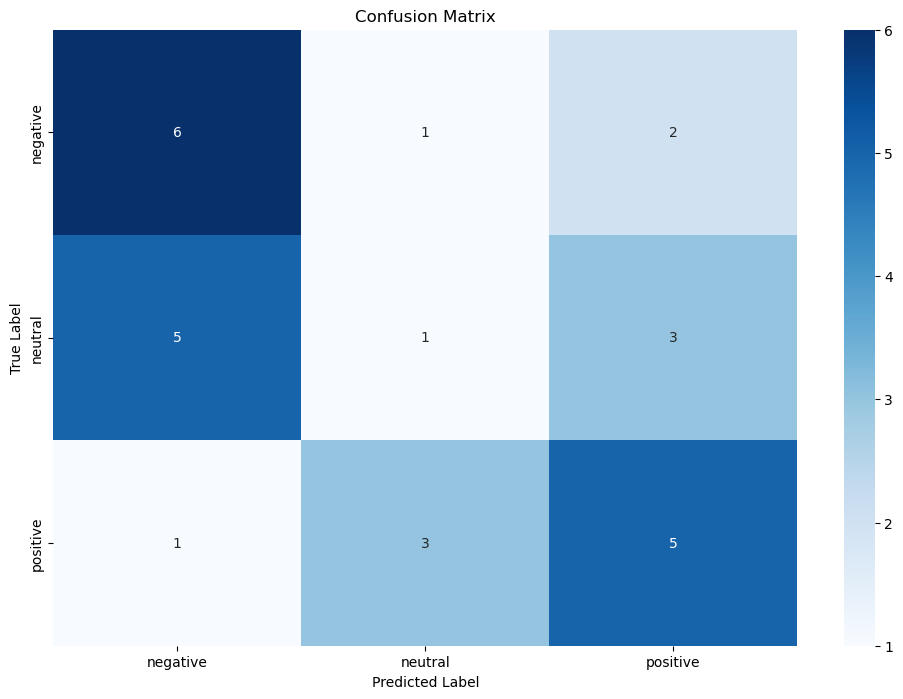


Overall Accuracy: 44.44%

Per-class Metrics:

Negative:
Precision: 50.00%
Recall: 66.67%

Neutral:
Precision: 20.00%
Recall: 11.11%

Positive:
Precision: 50.00%
Recall: 55.56%


In [41]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

# Parse predictions and true labels
results = {
    'positive': {
        'negation': [('positive', 'positive'), ('neutral', 'positive'), ('negative', 'positive')],
        'sarcasm': [('positive', 'positive'), ('positive', 'positive'), ('positive', 'positive')],
        'multipolarity': [('positive', 'positive'), ('neutral', 'positive'), ('neutral', 'positive')]
    },
    'negative': {
        'negation': [('negative', 'negative'), ('negative', 'negative'), ('negative', 'negative')],
        'sarcasm': [('neutral', 'negative'), ('positive', 'negative'), ('positive', 'negative')],
        'multipolarity': [('negative', 'negative'), ('negative', 'negative'), ('negative', 'negative')]
    },
    'neutral': {
        'negation': [('neutral', 'neutral'), ('negative', 'neutral'), ('negative', 'neutral')],
        'sarcasm': [('positive', 'neutral'), ('positive', 'neutral'), ('positive', 'neutral')],
        'multipolarity': [('negative', 'neutral'), ('negative', 'neutral'), ('negative', 'neutral')]
    }
}

# Create confusion matrix
labels = ['negative', 'neutral', 'positive']
confusion_mat = np.zeros((3, 3))
label_to_idx = {'negative': 0, 'neutral': 1, 'positive': 2}

# Fill confusion matrix
total_cases = 0
correct_predictions = 0

for true_sentiment, categories in results.items():
    for category, predictions in categories.items():
        for predicted, true in predictions:
            pred_idx = label_to_idx[predicted]
            true_idx = label_to_idx[true_sentiment]
            confusion_mat[true_idx][pred_idx] += 1
            total_cases += 1
            if predicted == true_sentiment:
                correct_predictions += 1

# Calculate metrics
accuracy = correct_predictions / total_cases
precision = {label: confusion_mat[label_to_idx[label]][label_to_idx[label]] / 
            confusion_mat[:, label_to_idx[label]].sum() if confusion_mat[:, label_to_idx[label]].sum() != 0 else 0 
            for label in labels}
recall = {label: confusion_mat[label_to_idx[label]][label_to_idx[label]] / 
         confusion_mat[label_to_idx[label], :].sum() if confusion_mat[label_to_idx[label], :].sum() != 0 else 0 
         for label in labels}

# Create visualization
plt.figure(figsize=(12, 8))
sns.heatmap(confusion_mat, annot=True, fmt='g', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print metrics
print(f"\nOverall Accuracy: {accuracy:.2%}")
print("\nPer-class Metrics:")
for label in labels:
    print(f"\n{label.capitalize()}:")
    print(f"Precision: {precision[label]:.2%}")
    print(f"Recall: {recall[label]:.2%}")